# New York City Taxi Trip Duration 03 - EDA version2

###   
### 목표 : 예측 모델의 성능을 높이기 위해 EDA를 추가로 수행한다.
###   
###   

### ● 위도와 경도를 이용해 이동거리를 계산한다.
### ● 새로운 날씨데이터를 가져와 추가한다.
###   
###   

## 1. 기존 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv", parse_dates = ['pickup_datetime', 'dropoff_datetime'])
test = pd.read_csv("test.csv", parse_dates = ['pickup_datetime'])
submission = pd.read_csv("sample_submission.csv")

train['pickup_year'] = train['pickup_datetime'].dt.year  
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_minute'] = train['pickup_datetime'].dt.minute
train['pickup_second'] = train['pickup_datetime'].dt.second
train["pickup_dayofweek"] = train["pickup_datetime"].dt.dayofweek 

test['pickup_year'] = test['pickup_datetime'].dt.year  
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_minute'] = test['pickup_datetime'].dt.minute
test['pickup_second'] = test['pickup_datetime'].dt.second
test["pickup_dayofweek"] = test["pickup_datetime"].dt.dayofweek 


train['store_and_fwd_flag_Y'] = train['store_and_fwd_flag'] == 'Y'
train['store_and_fwd_flag_N'] = train['store_and_fwd_flag'] == 'N'

test['store_and_fwd_flag_Y'] = test['store_and_fwd_flag'] == 'Y'
test['store_and_fwd_flag_N'] = test['store_and_fwd_flag'] == 'N'


train['vendor_1'] = train['vendor_id'] == 1
train['vendor_2'] = train['vendor_id'] == 2

test['vendor_1'] = test['vendor_id'] == 1
test['vendor_2'] = test['vendor_id'] == 2


train['passenger_0'] = train['passenger_count'] == 0
train['passenger_1'] = train['passenger_count'] == 1
train['passenger_2'] = train['passenger_count'] == 2
train['passenger_3'] = train['passenger_count'] == 3
train['passenger_4'] = train['passenger_count'] == 4
train['passenger_5'] = train['passenger_count'] == 5
train['passenger_6'] = train['passenger_count'] == 6
train['passenger_7'] = train['passenger_count'] == 7
train['passenger_8'] = train['passenger_count'] == 8
train['passenger_9'] = train['passenger_count'] == 9

test['passenger_0'] = test['passenger_count'] == 0
test['passenger_1'] = test['passenger_count'] == 1
test['passenger_2'] = test['passenger_count'] == 2
test['passenger_3'] = test['passenger_count'] == 3
test['passenger_4'] = test['passenger_count'] == 4
test['passenger_5'] = test['passenger_count'] == 5
test['passenger_6'] = test['passenger_count'] == 6
test['passenger_7'] = test['passenger_count'] == 7
test['passenger_8'] = test['passenger_count'] == 8
test['passenger_9'] = test['passenger_count'] == 9

print("완료!")

완료!


####     
####     

## 2. 이동거리 구하기

### 1) 하버사인 공식(Haversine formula)

#### 구에서 두 점 사이의 거리 구하는 공식. 위도와 경도 좌표를 가지고 구인 지구에서의 좌표사이의 거리를 구한다.
#### 참고 : https://gist.github.com/rochacbruno/2883505

In [3]:
import time
start = time.time()

from math import sin, cos, sqrt, atan2, radians 
import numpy as np
def haversine(train):
    lon1 = train['pickup_longitude']
    lat1 = train['pickup_latitude']
    lon2 = train['dropoff_longitude']
    lat2 = train['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * np.arcsin(sqrt(a)) 
    haversine_km = 6367 * c
    return haversine_km

train['haversine_distance'] = train.apply(lambda train: haversine(train), axis=1)

print('Running Time : %.02f초' % (time.time() - start))
train['haversine_distance'].head()

Running Time : 189.10초


0    1.497580
1    1.804374
2    6.381090
3    1.484566
4    1.187842
Name: haversine_distance, dtype: float64

In [4]:
import time
start = time.time()

import numpy as np
def haversine(test):
    lon1 = test['pickup_longitude']
    lat1 = test['pickup_latitude']
    lon2 = test['dropoff_longitude']
    lat2 = test['dropoff_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * np.arcsin(sqrt(a)) 
    haversine_km = 6367 * c
    return haversine_km

test['haversine_distance'] = test.apply(lambda test: haversine(test), axis=1)


print('Running Time : %.02f초' % (time.time() - start))
test['haversine_distance'].head()

Running Time : 78.99초


0    2.744701
1    2.757507
2    1.305335
3    5.265780
4    0.960239
Name: haversine_distance, dtype: float64

### 2) 맨하탄 거리(Manhattan Distance)

#### 택시거리 혹은 시가지 거리라고도 한다. 도로 사정 상 두 좌표 사이를 바로 잇는 선이 아닌 도로를 따라 이동하는 최단거리를 측정한다.
#### d = |x1 - x2| + |y1 - y2|
#### 경도 1도는 88.8km, 1분 1.48km  위도 1도 111km (뉴욕 기준)

In [6]:
import time
start = time.time()

def manhattan_distance(train):
    lon1 = train['pickup_longitude']
    lat1 = train['pickup_latitude']
    lon2 = train['dropoff_longitude']
    lat2 = train['dropoff_latitude']
    manhattan_km = (abs(lon1 - lon2)*111) + (abs(lat1 - lat2)*85.397)
    return manhattan_km

train['manhattan_distance'] = train.apply(lambda train: manhattan_distance(train), axis=1)

print('Running Time : %.02f초' % (time.time() - start))
train['manhattan_distance'].head()

Running Time : 174.18초


0    2.144611
1    2.749269
2    7.518789
3    1.378987
4    0.927187
Name: manhattan_distance, dtype: float64

In [7]:
import time
start = time.time()

def manhattan_distance(test):
    lon1 = test['pickup_longitude']
    lat1 = test['pickup_latitude']
    lon2 = test['dropoff_longitude']
    lat2 = test['dropoff_latitude']
    km = (abs(lon1 - lon2)*111) + (abs(lat1 - lat2)*85.397)
    return km

test['manhattan_distance'] = test.apply(lambda test: manhattan_distance(test), axis=1)

print('Running Time : %.02f초' % (time.time() - start))
test['manhattan_distance'].head()

Running Time : 73.13초


0    2.332044
1    2.587666
2    1.940002
3    6.907787
4    1.443189
Name: manhattan_distance, dtype: float64

####   
####   

## 3. 날씨 데이터 추가하기

### 1) 날씨데이터 처리

#### 2016년 1월 1일 ~ 2016년 6월 30일까지의 뉴욕 날씨 적용
#### NOOA 데이터 파일(https://www.ncdc.noaa.gov/)은 데이터에 결측치가 너무 많아 사용불가
#### wunderground data(https://www.wunderground.com/history/airport/KNYC) 데이터 사용
#### wunderground data은 뉴욕 센트럴파크 날씨 데이터로 시간이 아닌 일단위 데이터

In [ ]:
# 2018    Temp (°C)     이슬점 (°C)   습도 (%)     Sea Level Press. (hPa)  가시도 (km)   Wind (km/h)   Precip. (mm) rain snow fog  
# Mar     high/avg/low  high/avg/low high/avg/low high/avg/low            high/avg/low  high/avg/high     sum 
# 8          1/1/1  -      1/-1/-2    82/82/82    1005/1004.90/1004     16.1/15.6/14.5   15/12/-          0.0          
#         Temp = T      이슬점 = D     습도 = H    Sea level press =S      가시도 = V    Wind  = W

#### sea level press : 해수면 기압
#### 가시도 : 대상물을 인식하기 쉬움을 나타낸 지수
#### Precip : 강수량 ("T"는 강수량이 감지되었을 때 사용되는 "흔적"을 의미하지만 의미있는 측정은 충분하지 않습니다.)

#### w_weather.csv 데이터는 뉴욕 센트럴 파크 날씨 데이터를  가져와 수정한 데이터

In [1]:
import pandas as pd

weather = pd.read_csv("w_weather.csv", parse_dates = ['datetime'])
weather.head()

,datetime,T_high,T_avg,T_low,D_high,D_avg,D_low,H_high,H_avg,H_low,...,V_high,V_avg,V_low,W_high,W_avg,W_high.1,Precip. (mm),rain,snow,fog
0,2016-01-01,6.0,3.0,1.0,-3.0,-5.0,-9.0,59.0,52.0,44.0,...,16,16,16,27,12,42,0,,NaN,NaN
1,2016-01-02,4.0,2.0,0.0,-7.0,-8.0,-9.0,52.0,46.0,40.0,...,16,16,16,24,11,37,0,,NaN,NaN
2,2016-01-03,7.0,4.0,2.0,-5.0,-6.0,-7.0,56.0,47.0,37.0,...,16,16,16,27,13,42,0,,NaN,NaN
3,2016-01-04,2.0,-4.0,-10.0,-5.0,-13.0,-18.0,59.0,44.0,28.0,...,16,16,16,34,14,50,0,,NaN,NaN
4,2016-01-05,-2.0,-7.0,-12.0,-17.0,-19.0,-21.0,58.0,41.0,24.0,...,16,16,16,32,8,48,0,,NaN,NaN


In [2]:
weather.tail()

,datetime,T_high,T_avg,T_low,D_high,D_avg,D_low,H_high,H_avg,H_low,...,V_high,V_avg,V_low,W_high,W_avg,W_high.1,Precip. (mm),rain,snow,fog
179,2016-06-28,24.0,22.0,20.0,21.0,19.0,18.0,97.0,88.0,79.0,...,16,9,2,19,6,27,3.05,1,NaN,NaN
180,2016-06-29,28.0,24.0,19.0,19.0,17.0,13.0,93.0,67.0,40.0,...,16,12,3,16,4,27,0.25,1,NaN,NaN
181,2016-06-30,29.0,24.0,19.0,16.0,14.0,12.0,68.0,51.0,34.0,...,16,16,14,13,5,24,0,NaN,NaN,NaN
182,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN


#### 182행과 183행은 결측치 데이터. 삭제

In [3]:
weather = weather.drop([182, 183])
weather.tail()

,datetime,T_high,T_avg,T_low,D_high,D_avg,D_low,H_high,H_avg,H_low,...,V_high,V_avg,V_low,W_high,W_avg,W_high.1,Precip. (mm),rain,snow,fog
177,2016-06-26,31.0,25.0,19.0,16.0,13.0,8.0,68.0,53.0,37.0,...,16,14,11,16,4,27,0,,NaN,NaN
178,2016-06-27,28.0,24.0,19.0,20.0,16.0,9.0,97.0,71.0,44.0,...,16,13,4,19,8,35,11.43,1,NaN,NaN
179,2016-06-28,24.0,22.0,20.0,21.0,19.0,18.0,97.0,88.0,79.0,...,16,9,2,19,6,27,3.05,1,NaN,NaN
180,2016-06-29,28.0,24.0,19.0,19.0,17.0,13.0,93.0,67.0,40.0,...,16,12,3,16,4,27,0.25,1,NaN,NaN
181,2016-06-30,29.0,24.0,19.0,16.0,14.0,12.0,68.0,51.0,34.0,...,16,16,14,13,5,24,0,NaN,NaN,NaN


#### 그 외 결측치 확인

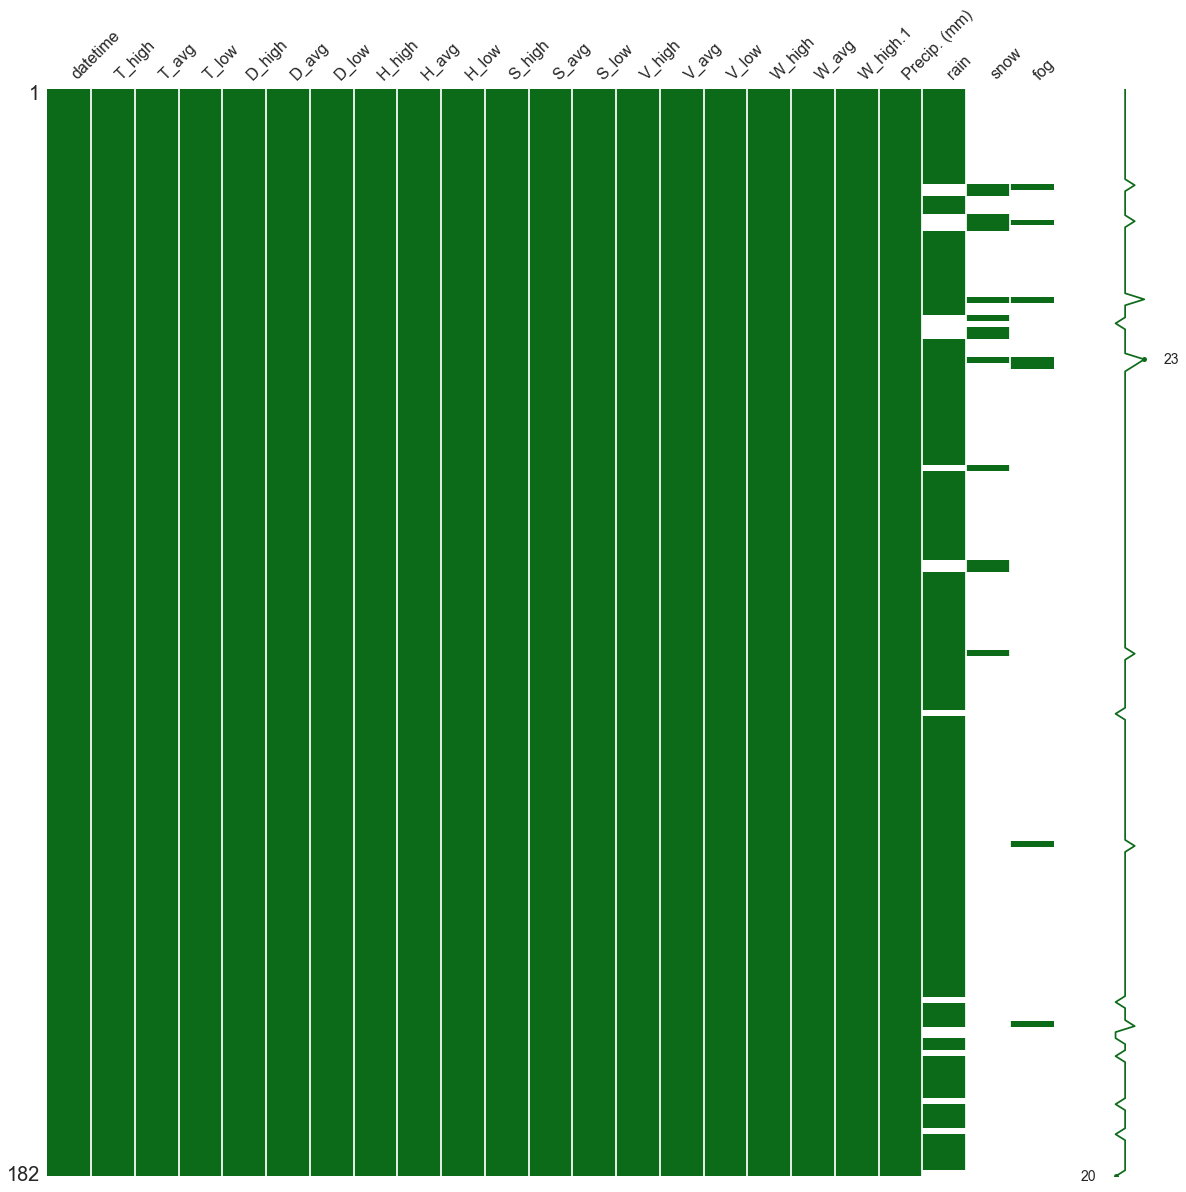

In [5]:
import missingno as msno

msno.matrix(df = weather, figsize = (20, 20), color = (0.05, 0.42, 0.1))

#### rain, snow, fog에서 결측치 발견. 다시 확인

In [6]:
weather.isnull().sum()

datetime          0
T_high            0
T_avg             0
T_low             0
D_high            0
D_avg             0
D_low             0
H_high            0
H_avg             0
H_low             0
S_high            0
S_avg             0
S_low             0
V_high            0
V_avg             0
V_low             0
W_high            0
W_avg             0
W_high.1          0
Precip. (mm)      0
rain             20
snow            168
fog             175
dtype: int64

In [7]:
weather.notnull().sum()

datetime        182
T_high          182
T_avg           182
T_low           182
D_high          182
D_avg           182
D_low           182
H_high          182
H_avg           182
H_low           182
S_high          182
S_avg           182
S_low           182
V_high          182
V_avg           182
V_low           182
W_high          182
W_avg           182
W_high.1        182
Precip. (mm)    182
rain            162
snow             14
fog               7
dtype: int64

#### 새로 만든 rain, snow, fog에만 결측치 관측됨
#### 비, 눈, 안개가 있으면 1, 아니면 0으로 해주기
#### 빈 곳은 1로 채우기
####   
#### 또한 작업할 때, weather_1이라는 파일을 만들어 원본 weather는 보존한다.

#### replace 함수 사용

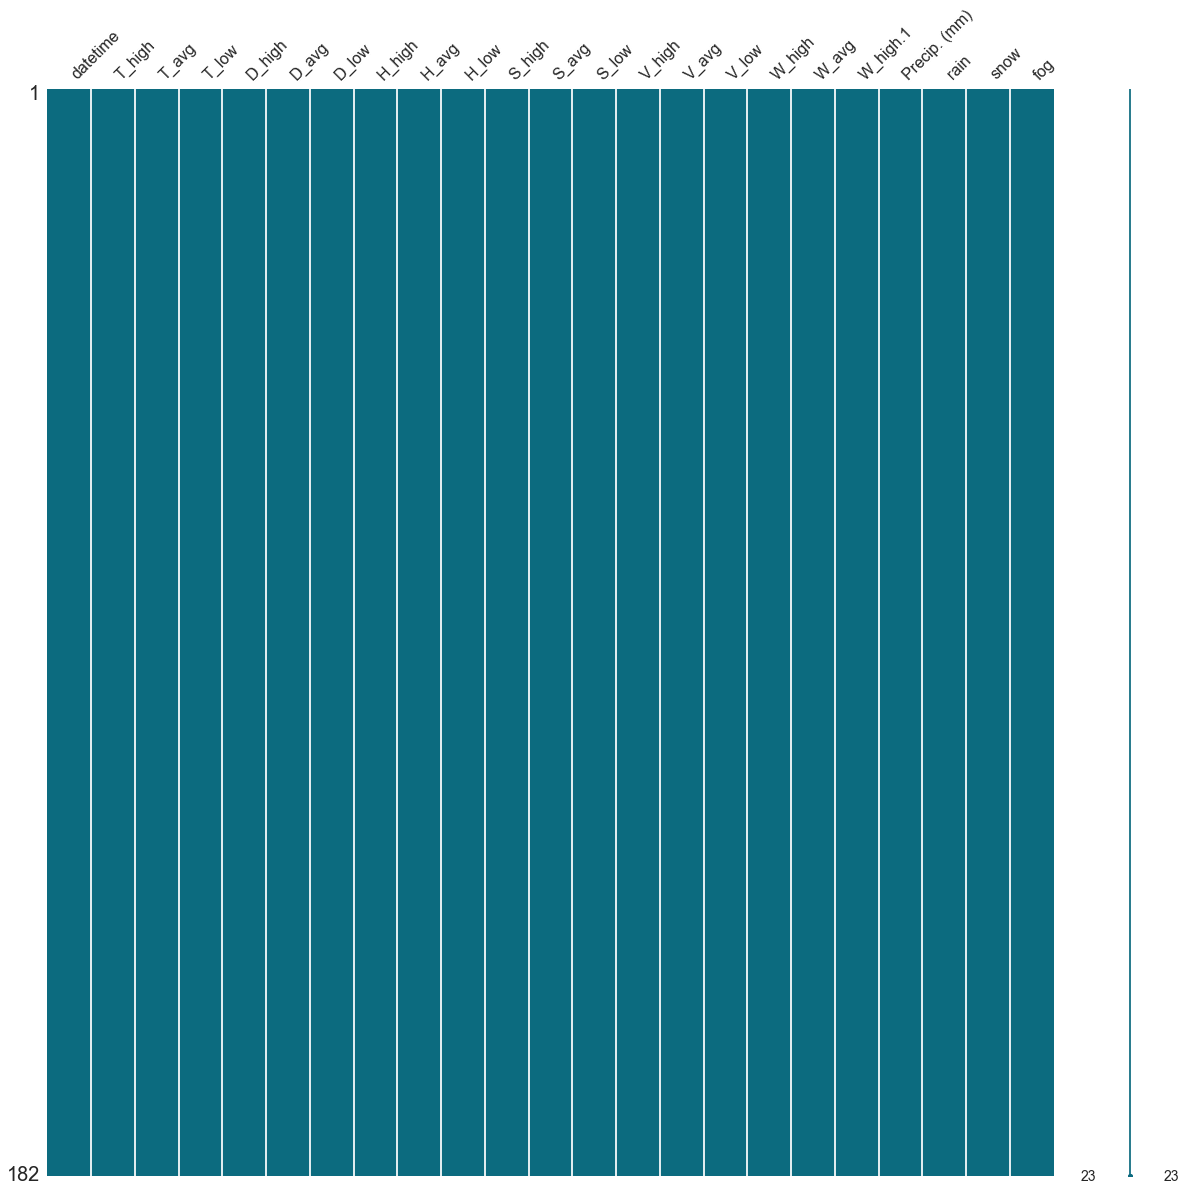

In [10]:
import numpy as np

weather_1 = weather.replace(np.NaN, 0)
msno.matrix(df = weather_1, figsize = (20, 20), color = (0.05, 0.42, 0.5))

In [11]:
weather_1.isnull().sum()

datetime        0
T_high          0
T_avg           0
T_low           0
D_high          0
D_avg           0
D_low           0
H_high          0
H_avg           0
H_low           0
S_high          0
S_avg           0
S_low           0
V_high          0
V_avg           0
V_low           0
W_high          0
W_avg           0
W_high.1        0
Precip. (mm)    0
rain            0
snow            0
fog             0
dtype: int64

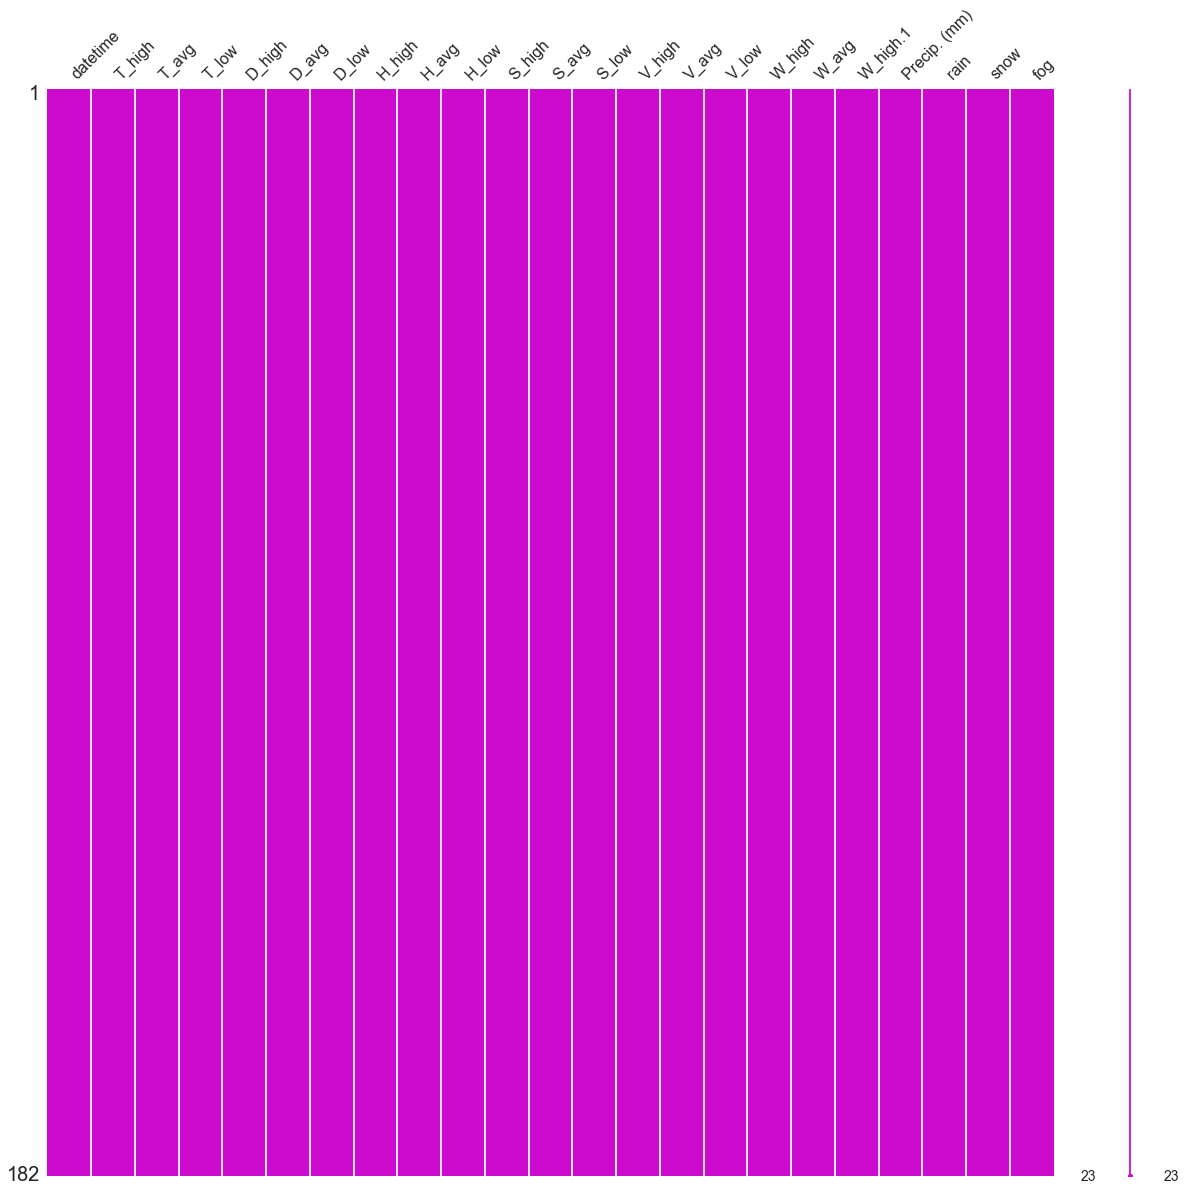

In [8]:
weather_2 = weather.fillna(0)
msno.matrix(df = weather_2, figsize = (20, 20), color = (0.8, 0.04, 0.8))  # RGB http://www.n2n.pe.kr/lev-1/color.htm 참고

In [12]:
weather_2.notnull().sum()

datetime        182
T_high          182
T_avg           182
T_low           182
D_high          182
D_avg           182
D_low           182
H_high          182
H_avg           182
H_low           182
S_high          182
S_avg           182
S_low           182
V_high          182
V_avg           182
V_low           182
W_high          182
W_avg           182
W_high.1        182
Precip. (mm)    182
rain            182
snow            182
fog             182
dtype: int64

In [13]:
weather_1[['rain', 'snow', 'fog']].head()

,rain,snow,fog
0,,0.0,0.0
1,,0.0,0.0
2,,0.0,0.0
3,,0.0,0.0
4,,0.0,0.0


#### rain에서 아예 없는 값이 나옴. 다시 처리

In [15]:
weather_1 = weather_1.replace(' ', 0)
weather_1[['rain','snow','fog']].head()

,rain,snow,fog
0,0,0.0,0.0
1,0,0.0,0.0
2,0,0.0,0.0
3,0,0.0,0.0
4,0,0.0,0.0


#### rain 데이터가 이상해 데이터 유형 살펴보기

In [16]:
for i in weather_1:
    print(i, '의 데이터 유형은 ', weather_1[i].dtype,' 입니다.')

datetime 의 데이터 유형은  datetime64[ns]  입니다.
T_high 의 데이터 유형은  float64  입니다.
T_avg 의 데이터 유형은  float64  입니다.
T_low 의 데이터 유형은  float64  입니다.
D_high 의 데이터 유형은  float64  입니다.
D_avg 의 데이터 유형은  float64  입니다.
D_low 의 데이터 유형은  float64  입니다.
H_high 의 데이터 유형은  float64  입니다.
H_avg 의 데이터 유형은  float64  입니다.
H_low 의 데이터 유형은  float64  입니다.
S_high 의 데이터 유형은  object  입니다.
S_avg 의 데이터 유형은  object  입니다.
S_low 의 데이터 유형은  object  입니다.
V_high 의 데이터 유형은  object  입니다.
V_avg 의 데이터 유형은  object  입니다.
V_low 의 데이터 유형은  object  입니다.
W_high 의 데이터 유형은  object  입니다.
W_avg 의 데이터 유형은  object  입니다.
W_high.1 의 데이터 유형은  object  입니다.
Precip. (mm) 의 데이터 유형은  object  입니다.
rain 의 데이터 유형은  object  입니다.
snow 의 데이터 유형은  float64  입니다.
fog 의 데이터 유형은  float64  입니다.


#### 결과를 보면 S_high부터 rain까지 데이터 유형이 float가 아니라 object. 이것을 float으로 바꿔줘야 함. 

#### 우선 Precip에서 'T'는 강우량이 감지되었지만 충분이 측정되지 않은 것을 의미하니 0으로 바꾸어줌

In [17]:
weather_1 = weather_1.replace("T", 0)
weather_1['Precip. (mm)'].value_counts()

0        104
0         20
0.25       8
1.02       4
1.27       4
2.29       4
4.06       3
0.51       3
6.1        2
1.52       2
11.43      2
3.81       1
2.79       1
1.78       1
13.72      1
3.05       1
41.91      1
25.65      1
5.59       1
9.65       1
6.35       1
10.16      1
58.67      1
30.99      1
7.37       1
11.18      1
5.08       1
3.56       1
7.62       1
18.54      1
23.11      1
45.72      1
4.57       1
13.46      1
11.94      1
0.76       1
15.49      1
Name: Precip. (mm), dtype: int64

In [18]:
weather['Precip. (mm)'].value_counts()

0        104
T         20
0.25       8
2.29       4
1.02       4
1.27       4
4.06       3
0.51       3
6.1        2
1.52       2
11.43      2
1.78       1
6.35       1
9.65       1
25.65      1
3.81       1
13.46      1
13.72      1
3.05       1
41.91      1
5.59       1
7.62       1
10.16      1
30.99      1
4.57       1
11.94      1
7.37       1
11.18      1
58.67      1
3.56       1
2.79       1
5.08       1
0.76       1
18.54      1
23.11      1
45.72      1
15.49      1
Name: Precip. (mm), dtype: int64

#### 원본과 비교했을 시 T는 사라짐.

In [24]:
weather['W_high.1'].value_counts()

35    15
32    12
27    11
29    10
48    10
42     9
40     9
31     9
37     9
39     9
34     8
-      7
26     7
56     6
64     5
50     5
24     4
43     4
58     4
45     4
55     3
23     3
47     3
52     3
19     2
60     2
72     2
53     2
68     1
61     1
21     1
16     1
69     1
Name: W_high.1, dtype: int64

#### '-'이라는 문자열이 있음. 처리해주어야 함 

In [25]:
weather_1 = weather_1.replace("-", 0)
weather_1['W_high.1'].value_counts()

35    15
32    12
27    11
48    10
29    10
40     9
42     9
31     9
37     9
39     9
34     8
0      7
26     7
56     6
64     5
50     5
58     4
43     4
45     4
24     4
55     3
23     3
52     3
47     3
19     2
72     2
53     2
60     2
61     1
21     1
69     1
16     1
68     1
Name: W_high.1, dtype: int64

#### 데이터 유형 바꾸기에 방해가 되는 문자열 변수들 처리 완료
#### 이제 모든 데이터에 관해 float64 유형으로 데이터 처리

In [26]:
for i in weather_1:
    if weather_1[i].dtype == "object":
        weather_1[i] = weather_1[i].astype(np.float64)
    else :
        weather_1[i] = weather_1[i]
        
for i in weather_1:
    print(i, '의 데이터 유형은 ', weather_1[i].dtype,' 입니다.')

datetime 의 데이터 유형은  datetime64[ns]  입니다.
T_high 의 데이터 유형은  float64  입니다.
T_avg 의 데이터 유형은  float64  입니다.
T_low 의 데이터 유형은  float64  입니다.
D_high 의 데이터 유형은  float64  입니다.
D_avg 의 데이터 유형은  float64  입니다.
D_low 의 데이터 유형은  float64  입니다.
H_high 의 데이터 유형은  float64  입니다.
H_avg 의 데이터 유형은  float64  입니다.
H_low 의 데이터 유형은  float64  입니다.
S_high 의 데이터 유형은  float64  입니다.
S_avg 의 데이터 유형은  float64  입니다.
S_low 의 데이터 유형은  float64  입니다.
V_high 의 데이터 유형은  float64  입니다.
V_avg 의 데이터 유형은  float64  입니다.
V_low 의 데이터 유형은  float64  입니다.
W_high 의 데이터 유형은  float64  입니다.
W_avg 의 데이터 유형은  float64  입니다.
W_high.1 의 데이터 유형은  float64  입니다.
Precip. (mm) 의 데이터 유형은  float64  입니다.
rain 의 데이터 유형은  float64  입니다.
snow 의 데이터 유형은  float64  입니다.
fog 의 데이터 유형은  float64  입니다.


In [27]:
weather_1.head()

,datetime,T_high,T_avg,T_low,D_high,D_avg,D_low,H_high,H_avg,H_low,...,V_high,V_avg,V_low,W_high,W_avg,W_high.1,Precip. (mm),rain,snow,fog
0,2016-01-01,6.0,3.0,1.0,-3.0,-5.0,-9.0,59.0,52.0,44.0,...,16.0,16.0,16.0,27.0,12.0,42.0,0.0,0.0,0.0,0.0
1,2016-01-02,4.0,2.0,0.0,-7.0,-8.0,-9.0,52.0,46.0,40.0,...,16.0,16.0,16.0,24.0,11.0,37.0,0.0,0.0,0.0,0.0
2,2016-01-03,7.0,4.0,2.0,-5.0,-6.0,-7.0,56.0,47.0,37.0,...,16.0,16.0,16.0,27.0,13.0,42.0,0.0,0.0,0.0,0.0
3,2016-01-04,2.0,-4.0,-10.0,-5.0,-13.0,-18.0,59.0,44.0,28.0,...,16.0,16.0,16.0,34.0,14.0,50.0,0.0,0.0,0.0,0.0
4,2016-01-05,-2.0,-7.0,-12.0,-17.0,-19.0,-21.0,58.0,41.0,24.0,...,16.0,16.0,16.0,32.0,8.0,48.0,0.0,0.0,0.0,0.0


In [28]:
weather_1.to_csv("weather.csv", index=False)

#### 데이터 정리 최종 데이터 'weather'. csv 파일로도 백업 후 불러오기

####   

In [5]:
weather = pd.read_csv("weather.csv", parse_dates = ['datetime'])
weather.head()

,datetime,T_high,T_avg,T_low,D_high,D_avg,D_low,H_high,H_avg,H_low,...,V_high,V_avg,V_low,W_high,W_avg,W_high.1,Precip. (mm),rain,snow,fog
0,2016-01-01,6.0,3.0,1.0,-3.0,-5.0,-9.0,59.0,52.0,44.0,...,16.0,16.0,16.0,27.0,12.0,42.0,0.0,0.0,0.0,0.0
1,2016-01-02,4.0,2.0,0.0,-7.0,-8.0,-9.0,52.0,46.0,40.0,...,16.0,16.0,16.0,24.0,11.0,37.0,0.0,0.0,0.0,0.0
2,2016-01-03,7.0,4.0,2.0,-5.0,-6.0,-7.0,56.0,47.0,37.0,...,16.0,16.0,16.0,27.0,13.0,42.0,0.0,0.0,0.0,0.0
3,2016-01-04,2.0,-4.0,-10.0,-5.0,-13.0,-18.0,59.0,44.0,28.0,...,16.0,16.0,16.0,34.0,14.0,50.0,0.0,0.0,0.0,0.0
4,2016-01-05,-2.0,-7.0,-12.0,-17.0,-19.0,-21.0,58.0,41.0,24.0,...,16.0,16.0,16.0,32.0,8.0,48.0,0.0,0.0,0.0,0.0


####  train, test 날짜 데이터와의 비교를 위해 'datetime을 '년', '월', '일'로 분리한다.

In [10]:
weather['year'] = weather['datetime'].dt.year  
weather['month'] = weather['datetime'].dt.month
weather['day'] = weather['datetime'].dt.day

weather[['year', 'month', 'day', 'rain', 'snow', 'fog']].head()

,year,month,day,rain,snow,fog
0,2016,1,1,0.0,0.0,0.0
1,2016,1,2,0.0,0.0,0.0
2,2016,1,3,0.0,0.0,0.0
3,2016,1,4,0.0,0.0,0.0
4,2016,1,5,0.0,0.0,0.0


#### train과 test 데이터의 '년', '월', '일' 확인

In [12]:
train[['pickup_year','pickup_month', 'pickup_day']].head()

,pickup_year,pickup_month,pickup_day
0,2016,3,14
1,2016,6,12
2,2016,1,19
3,2016,4,6
4,2016,3,26


In [11]:
test[['pickup_year','pickup_month', 'pickup_day']].head()

,pickup_year,pickup_month,pickup_day
0,2016,6,30
1,2016,6,30
2,2016,6,30
3,2016,6,30
4,2016,6,30


In [16]:
weather[['year', 'month', 'day', 'rain', 'snow', 'fog']].head()

,year,month,day,rain,snow,fog
0,2016,1,1,0.0,0.0,0.0
1,2016,1,2,0.0,0.0,0.0
2,2016,1,3,0.0,0.0,0.0
3,2016,1,4,0.0,0.0,0.0
4,2016,1,5,0.0,0.0,0.0


#### 데이터를 합치기 위해 weather 데이터에서 'year', 'month', 'day'를 train 데이터의 'pickup_year','pickup_month', 'pickup_day'로 열(컬럼) 이름을 바꿔줌

In [32]:
weather = weather.rename(columns = {'year' : 'pickup_year', 'month' : 'pickup_month', 'day' : 'pickup_day'})
weather[['pickup_year','pickup_month', 'pickup_day', 'rain', 'snow', 'fog' ]].head()

,pickup_year,pickup_month,pickup_day,rain,snow,fog
0,2016,1,1,0.0,0.0,0.0
1,2016,1,2,0.0,0.0,0.0
2,2016,1,3,0.0,0.0,0.0
3,2016,1,4,0.0,0.0,0.0
4,2016,1,5,0.0,0.0,0.0


#### merge 함수 사용해 데이터 합치기

In [33]:
train = pd.merge(train, weather)

In [34]:
train[['pickup_year','pickup_month', 'pickup_day', 'passenger_count', 'store_and_fwd_flag', 'rain', 'snow', 'fog']].head()

,pickup_year,pickup_month,pickup_day,passenger_count,store_and_fwd_flag,rain,snow,fog
0,2016,3,14,1,N,1.0,0.0,0.0
1,2016,3,14,1,N,1.0,0.0,0.0
2,2016,3,14,1,N,1.0,0.0,0.0
3,2016,3,14,3,N,1.0,0.0,0.0
4,2016,3,14,1,N,1.0,0.0,0.0


In [35]:
test = pd.merge(test, weather)

In [36]:
test[['pickup_year','pickup_month', 'pickup_day', 'passenger_count', 'store_and_fwd_flag', 'rain', 'snow', 'fog']].head()

,pickup_year,pickup_month,pickup_day,passenger_count,store_and_fwd_flag,rain,snow,fog
0,2016,6,30,1,N,0.0,0.0,0.0
1,2016,6,30,1,N,0.0,0.0,0.0
2,2016,6,30,1,N,0.0,0.0,0.0
3,2016,6,30,1,N,0.0,0.0,0.0
4,2016,6,30,1,N,0.0,0.0,0.0
